In [1]:
import numpy as np

import torch
import torch.nn as nn
import  torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import  train_test_split

import matplotlib.pyplot as plt

from torchsummary import summary

import torchvision
import copy

In [2]:
#Using gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import and inspect data

In [3]:
#download data
c_data = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

In [4]:
#inspect the data

# the categories
print(c_data.classes)
print(str(len(c_data.classes)) + 'classes')

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27classes


In [5]:
print('\n Data size')
print(c_data.data.shape)

#transform to 4D tensor for conv layers (and transform from int8 to float)
images = c_data.data.view([124800,1,28,28]).float() #availabel data instances, input color channel, height, weight
print('\nTensor Data: ')
print(images.shape)


 Data size
torch.Size([124800, 28, 28])

Tensor Data: 
torch.Size([124800, 1, 28, 28])


In [6]:
# Class 'N/A' doen't exist in the data
print(torch.sum(c_data.targets==0))

tensor(0)


In [7]:
# how ever it casues problem in One hot encoding
torch.unique(c_data.targets)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [8]:
c_data.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [9]:
# So therefore I will eliminate it and substract 1 from the original

letter_cat= c_data.classes[1:]

#relabel labels to start at 0
labels = copy.deepcopy(c_data.targets)-1
print(labels.shape)

###
print(torch.sum(labels==0))
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

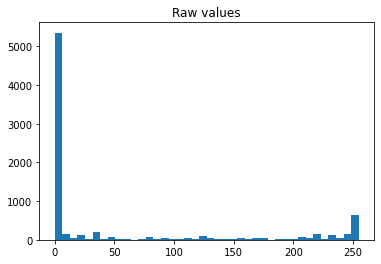

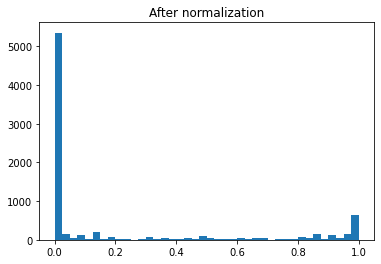

In [10]:
# next issue: normalize the images
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('Raw values')
plt.show()

###
images /= torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40)
plt.title('After normalization')
plt.show()

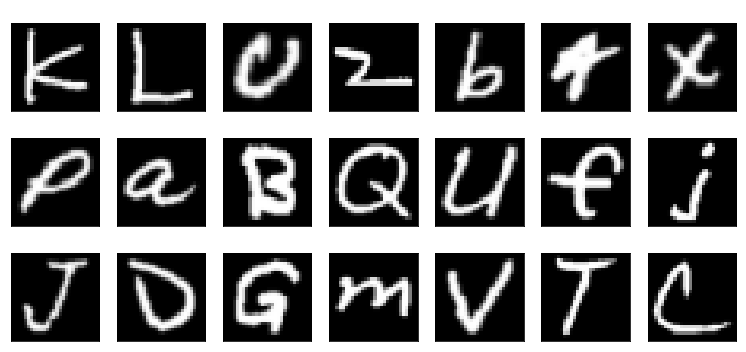

In [11]:
# visualize some images
fig,axs =plt.subplots(3,7,figsize=(13,6))

for i, ax in enumerate(axs.flatten()):

    #pick a random image and its target letter
    which_pic = np.random.randint(images.shape[0])
    I = np.squeeze(images[which_pic,:,:])
    letter = letter_cat[labels[which_pic]]

    #visualize
    ax.imshow(I.T,cmap='gray')
    ax.set_title('The letter is "%s"'%letter,c='white')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# Create train/test groups using Dataloader

In [12]:
#Step2: use sklearn to split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3)

#step 3: Converting into pytorch tensor dataset
train_data = TensorDataset(X_train,y_train)
test_data = TensorDataset(X_test,y_test)

#Translate into dataloader object
batch_sz= 64
train_aloader = DataLoader(train_data,batch_size=batch_sz,shuffle=True,drop_last=True)
test_loder = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [13]:
#Check size(should be images X channels X width X height
print(train_aloader.dataset.tensors[0].shape)
print(train_aloader.dataset.tensors[1].shape)

torch.Size([87360, 1, 28, 28])
torch.Size([87360])


# Create the Dl model

In [14]:
# Create a class for the model
def make_net(printtoggle=False):

    class emnist_net(nn.Module):
        def __init__(self):
            super().__init__()
            # print toggle
            self.print = printtoggle

            ### Feature map layers
            #first convolution layer
            self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(6) #input the number of channles in the layer
            #output_size: (28+2*1-3)/1+1 = 28/2 = 14 (/2 because of pooling)

            #second convolution layer
            self.conv2 = nn.Conv2d(in_channels=6,out_channels=6,kernel_size=3,padding=1)
            self.bnorm2 = nn.BatchNorm2d(6)
            #output_size: (14+2*1-3)/1+1 = 14/2 = 7 (/2 bec of pool)

            ####________Linear decision layer______####
            self.fc1 = nn.Linear(7*7*6,50)  #h X y X channels
            self.fc2 = nn.Linear(50,26)

        def forward(self,x):
            if self.print: print(f"Input: {list(x.shape)}")

            #first block convolution->maxpool->batchnorm-> relu
            x = F.max_pool2d(self.conv1(x),2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f"Second CPR block{list(x.shape)}")

            #reshape for linear layer
            n_units = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(n_units))
            if self.print: print(f'Vectorized: {list(x.shape)}')

            return x

    #create a class instance
    net = emnist_net()

    #loss function
    loss_func = nn.CrossEntropyLoss()

    #optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.001)

    return net,loss_func,optimizer

In [15]:
net,loss_func,optimizer = make_net(printtoggle=True)

X,y = next(iter(test_loder))
y_hat = net(X)

print(y_hat.shape)
loss = loss_func(y_hat,torch.squeeze(y))
print("")
print(loss)

Input: [37440, 1, 28, 28]
Second CPR block[37440, 6, 14, 14]
Vectorized: [37440, 1176]
torch.Size([37440, 1176])

tensor(7.7088, grad_fn=<NllLossBackward0>)


# Train Model

In [16]:
# a function that trains the model

def function_2_train():

    #number of epochs
    n_epochs = 10

    #create a new model
    net,loss_fun, optimizer = make_net()

    #send the model to gpu
    net.to(device=device)

    #training losses
    train_loss = torch.zeros(n_epochs)
    test_loss = torch.zeros(n_epochs)
    train_error = torch.zeros(n_epochs)
    test_error = torch.zeros(n_epochs)

    #loop over epochs
    for epochi in range(n_epochs):

        #loop over training data batches
        net.train()
        batch_er = []
        batch_ls = []

        for X,y in train_aloader:
            X = X.to(device)
            y= y.to(device)
            y_hat = net(X)
            loss = loss_fun(y_hat,y)

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #loss and error from this batch
            batch_ls.append(loss.item())
            batch_er.append(   torch.mean((torch.argmax(y_hat,axis=1) !=y).float()).item()  )
        #end of batch loop

        train_loss[epochi] = np.mean(batch_ls)
        train_error[epochi] = 100*np.mean(batch_er)


        #test performance
        net.eval()
        X,y = next(iter(test_loder))
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_hat = net(X)
            loss = loss_fun(y_hat,y)

        test_loss[epochi] = loss.item()
        test_error[epochi] = 100*torch.mean((torch.argmax(y_hat,axis=1)!=y).float()).item()

    #end of epochs

    return train_loss,test_loss,train_error,test_error

# Run and show the result

In [17]:
train_loss,test_loss,train_error,test_error = function_2_train()

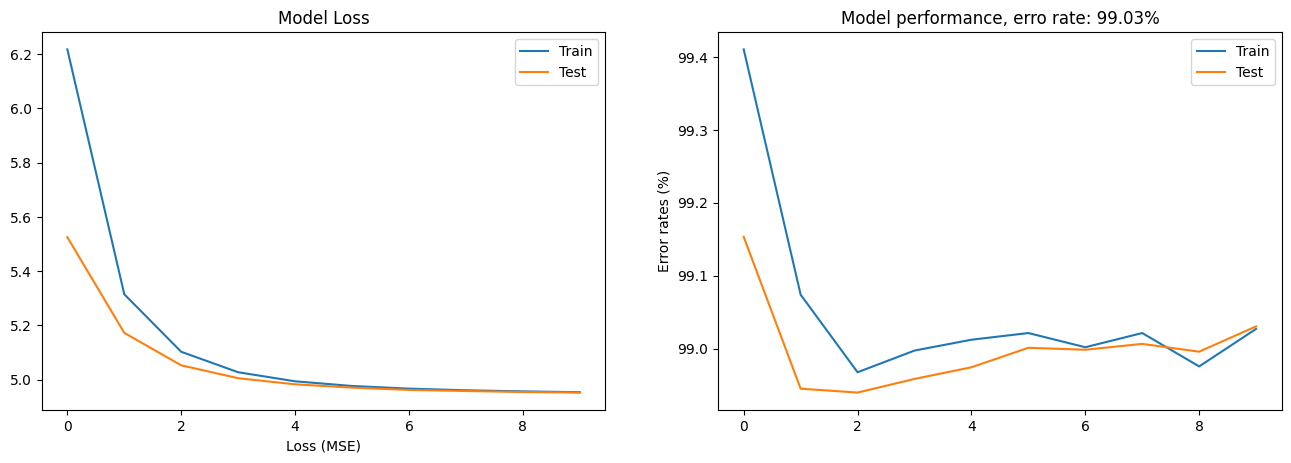

In [18]:
fig,ax = plt.subplots(1,2,figsize=(16,5),dpi=100)

ax[0].plot(train_loss,label='Train')
ax[0].plot(test_loss,label='Test')
ax[0].set_xlabel('Loss (MSE)')
ax[0].set_title('Model Loss')
ax[0].legend()
ax[1].plot(train_error,label='Train')
ax[1].plot(test_error,label='Test')
ax[1].set_label('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Model performance, erro rate: {test_error[-1]:.2f}%')
plt.legend()

plt.show()

In [19]:
import sklearn.metrics as skm

In [ ]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(y_hat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(26),labels=letter_cat)
plt.yticks(range(26),labels=letter_cat)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()